In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 30


In [3]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

data_sets = {
    'train': torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='./data', download=True, transform=data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}


Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [5]:
import random


class PermuteAdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, p=0.01, eps=1e-5):
        super(PermuteAdaptiveInstanceNorm2d, self).__init__()
        self.p = p
        self.eps = eps

    def forward(self, x):
        permute = random.random() < self.p
        if permute and self.training:
            perm_indices = torch.randperm(x.size()[0])
        else:
            return x
        size = x.size()
        N, C, H, W = size
        if (H, W) == (1, 1):
            
            return x
        return adaptive_instance_normalization(x, x[perm_indices], self.eps)

    def extra_repr(self) -> str:
        return 'p={}'.format(
            self.p
        )


def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C, H, W = size
    feat_std = torch.sqrt(feat.view(N, C, -1).var(dim=2).view(N, C, 1, 1) + eps)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat, eps=1e-5):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat.detach(), eps)
    content_mean, content_std = calc_mean_std(content_feat, eps)
    content_std = content_std + eps  # to avoid division by 0
    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


In [6]:
class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
    
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.perumte_adain = PermuteAdaptiveInstanceNorm2d(p=0.01)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.perumte_adain(output)
        output = self.conv2_x(output)
        output = self.perumte_adain(output)
        output = self.conv3_x(output)
        output = self.perumte_adain(output)
        output = self.conv4_x(output)
        output = self.perumte_adain(output)
        output = self.conv5_x(output)
        output = self.perumte_adain(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


def resnet50():
    
    return ResNet(BottleNeck, [3, 4, 6, 3])





In [7]:
model = resnet50()

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [8]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc)
            test_losses.append(epoch_loss)
            
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')
    

Epoch 0


train-loss: 0.0672, train-acc: 0.0422
test loss: 0.0606, test acc: 0.0875

Epoch 1


train-loss: 0.0636, train-acc: 0.0974
test loss: 0.0574, test acc: 0.1554

Epoch 2


train-loss: 0.0605, train-acc: 0.1581
test loss: 0.0540, test acc: 0.2354

Epoch 3


train-loss: 0.0574, train-acc: 0.2312
test loss: 0.0509, test acc: 0.3065

Epoch 4


train-loss: 0.0544, train-acc: 0.2973
test loss: 0.0482, test acc: 0.3554

Epoch 5


train-loss: 0.0517, train-acc: 0.3586
test loss: 0.0466, test acc: 0.3579

Epoch 6


train-loss: 0.0493, train-acc: 0.4068
test loss: 0.0440, test acc: 0.4885

Epoch 7


train-loss: 0.0472, train-acc: 0.4514
test loss: 0.0418, test acc: 0.5227

Epoch 8


train-loss: 0.0452, train-acc: 0.4947
test loss: 0.0397, test acc: 0.5860

Epoch 9


train-loss: 0.0433, train-acc: 0.5313
test loss: 0.0378, test acc: 0.6138

Epoch 10


train-loss: 0.0413, train-acc: 0.6522
test loss: 0.0355, test acc: 0.7633

Epoch 11


train-loss: 0.0394, train-acc: 0.6899
test loss: 0.03

In [9]:
train_acces = [t.cpu().numpy() for t in train_acces]
test_acces = [t.cpu().numpy() for t in test_acces]


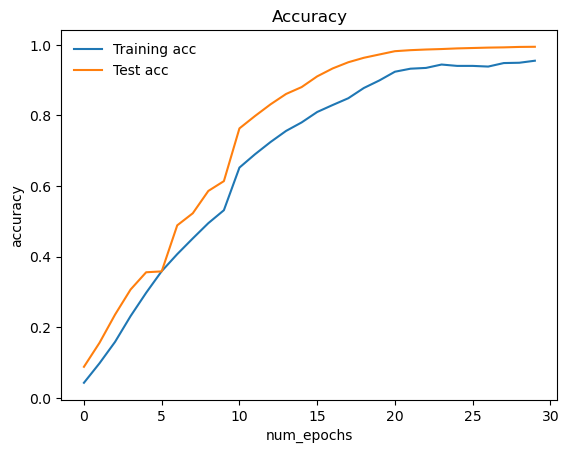

In [10]:
plt.title("Accuracy")
plt.plot(train_acces, label='Training acc')
plt.plot(test_acces, label='Validation acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)


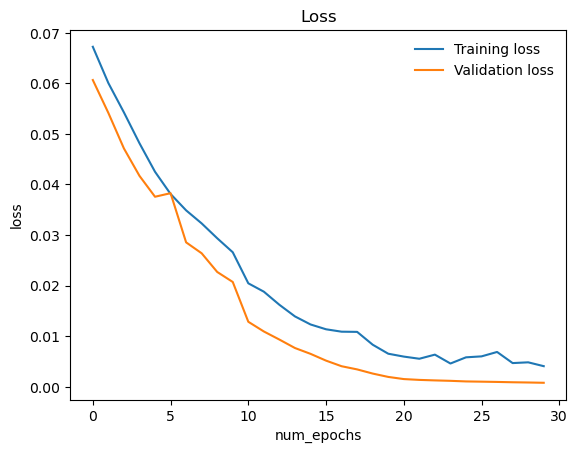

In [11]:
plt.title("Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()


In [12]:
train_acces

[array(0.04216),
 array(0.09744),
 array(0.15808),
 array(0.23124),
 array(0.29728),
 array(0.35856),
 array(0.40684),
 array(0.45136),
 array(0.49466),
 array(0.53134),
 array(0.65216),
 array(0.68992),
 array(0.72464),
 array(0.75616),
 array(0.7802),
 array(0.80976),
 array(0.82964),
 array(0.84874),
 array(0.87776),
 array(0.89922),
 array(0.92394),
 array(0.93252),
 array(0.93472),
 array(0.94432),
 array(0.94046),
 array(0.94046),
 array(0.93856),
 array(0.9485),
 array(0.94936),
 array(0.95512)]

In [13]:
test_acces

[array(0.08748),
 array(0.15544),
 array(0.23536),
 array(0.30654),
 array(0.35544),
 array(0.35794),
 array(0.48848),
 array(0.52268),
 array(0.58602),
 array(0.61378),
 array(0.76328),
 array(0.79834),
 array(0.83148),
 array(0.8609),
 array(0.88038),
 array(0.91076),
 array(0.93334),
 array(0.95076),
 array(0.96344),
 array(0.97282),
 array(0.98214),
 array(0.98506),
 array(0.9869),
 array(0.98824),
 array(0.99004),
 array(0.99116),
 array(0.9923),
 array(0.99298),
 array(0.99422),
 array(0.99464)]

In [14]:
train_losses

[0.06722005692958832,
 0.060044256839752196,
 0.05424667700767517,
 0.04815137708187103,
 0.04251178099870682,
 0.038122631421089175,
 0.03488264726638794,
 0.032303405241966246,
 0.029366814687252045,
 0.026598808360099792,
 0.020461645735502243,
 0.01880642014861107,
 0.016213832358717917,
 0.01391872832775116,
 0.0123291183167696,
 0.011372798580527305,
 0.010897892781794071,
 0.01086020061582327,
 0.008323960313796997,
 0.0065436263631284235,
 0.0059748616808652875,
 0.005549017755389214,
 0.00636248852878809,
 0.004607395713925362,
 0.005830109513998032,
 0.006018285149261356,
 0.006890087337344885,
 0.0046920708268880845,
 0.004841524852141738,
 0.004081299456506968]

In [15]:
test_losses

[0.06064858961105347,
 0.05414174903392792,
 0.04712313051223755,
 0.041704761481285095,
 0.03757337163209915,
 0.038279350719451904,
 0.028556188008785247,
 0.02639724677801132,
 0.022705122065544127,
 0.020724195271730424,
 0.012859150663614273,
 0.010938884997963905,
 0.009339249112010003,
 0.00767133472263813,
 0.0065200134298205375,
 0.005176945598125458,
 0.004069681904613972,
 0.003442650153264403,
 0.0026200255565345287,
 0.0019558159156888725,
 0.001531020219773054,
 0.0013677740590646863,
 0.0012681839949265123,
 0.0011840753830596805,
 0.0010653662283159793,
 0.0010180191200971603,
 0.0009661075558885932,
 0.0009012636325322091,
 0.0008553148268721998,
 0.0007980247106030583]